In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./data/bbc_text_cls.csv')
df

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business
...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,tech
2221,Spam e-mails tempt net shoppers\n\nComputer us...,tech
2222,Be careful how you code\n\nA new European dire...,tech
2223,US cyber security chief resigns\n\nThe man mak...,tech


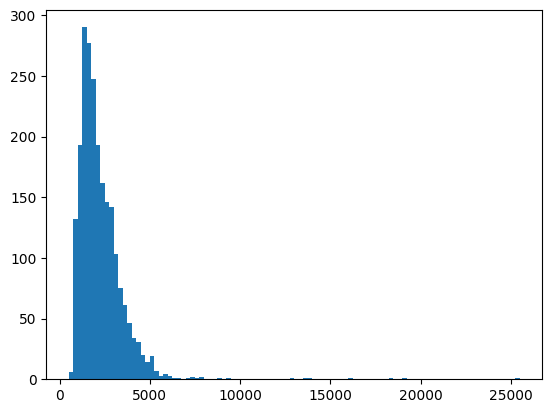

In [3]:
lens = df.text.apply(len)
plt.hist(lens, bins=100)
plt.show()

In [4]:
maxlen = np.quantile(df.text.apply(len), q=0.99)
print(len(df))
df = df[df.text.apply(len) < maxlen].reset_index()
print(len(df))

2225
2202


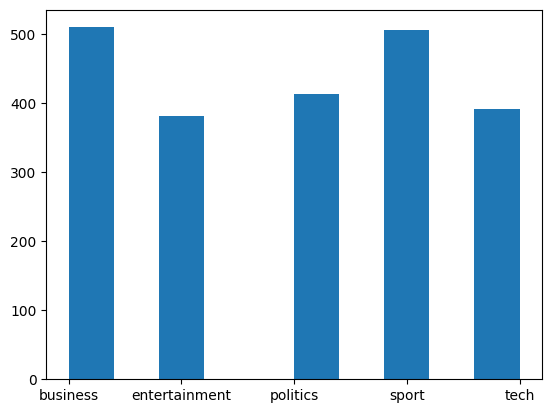

In [5]:
plt.hist(df.labels)
plt.show()

In [7]:
class ArticlesDataset(Dataset):
    UNK_TOKEN = 'UNK'
    PAD_TOKEN = 'PAD'

    @staticmethod
    def preprocess_text(text: str) -> list[str]:
        text = text.lower()  # lower characters
        text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove special characters
        text_tokenized = word_tokenize(text)  # split by words

        lemmatizer = WordNetLemmatizer()  # lemmatize
        text_tokenized = [lemmatizer.lemmatize(word) for word in text_tokenized]

        english_stopwords = set(stopwords.words("english"))    # remove stopwords
        text_tokenized = [word for word in text_tokenized if word not in english_stopwords]
        return text_tokenized

    @classmethod
    def create_vocab(cls, texts: list[list[str]]) -> dict:
        vocab = {
            cls.UNK_TOKEN: 0,
            cls.PAD_TOKEN: 1,
        }
        for text in texts:
            for word in text:
                vocab[word] = vocab.get(word, len(vocab))
        return vocab

    @property
    def unk_token_id(self):
        return self.vocab[self.UNK_TOKEN]

    @property
    def pad_token_id(self):
        return self.vocab[self.PAD_TOKEN]

    def __init__(self, data):
        texts_tokenized = data.text.apply(self.preprocess_text).to_list()
        self.vocab = self.create_vocab(texts_tokenized)

        unique_labels = set(data.labels.to_list())
        self.labels_vocab = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = data.labels.apply(lambda x: self.labels_vocab[x])

        self.data = list()
        for text in texts_tokenized:
            self.data.append(list())
            for word in text:
                self.data[-1].append(self.vocab[word])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index) -> torch.Tensor:
        tokens = self.data[index]
        label = self.labels[index]

        tokens = torch.tensor(tokens)
        label = torch.tensor(label)
        return tokens, label

In [8]:
dataset = ArticlesDataset(df)
len(dataset)

2202

In [9]:
def collate_fn(batch, pad_token):
    tokens, labels = zip(*batch)
    tokens = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=True, padding_value=pad_token)
    labels = torch.tensor(labels)
    return tokens, labels

In [10]:
dl = DataLoader(dataset, shuffle=False, batch_size=32, collate_fn=lambda x: collate_fn(x, pad_token=dataset.pad_token_id))
len(dl)

69

Пусть $h^{i} \in \mathbb{R}^{T}$ - эмбеддинг $i$-го слова, где $T$ - количество тем. \
Взвешенный контекст слова $i$ можно получить путем умножения эмбеддингов слов последовательности на вектор коэффициентов контекста $f$:
$$ c^{i} = f^{i} H, \quad H \in \mathbb{R}^{d \times T}, \quad f \in \mathbb{R}^{d}$$
Здесь $d$ - длина текущего документа, а сам вектор контекста имеет форму
$$f^{i} = (0, \dots, 0_{i - n - 1}, \gamma, \gamma(1 - \gamma), \dots, \gamma(1 - \gamma)^{n}, 0_{i}, \gamma(1 - \gamma)^{n}, \dots, \gamma(1 - \gamma), \gamma, 0_{i + n + 1}, \dots, 0)$$
$k$ - длина контекста. Как можно заметить, само слово при этом в собственном контексте не присутствует. Для всего документа эта операция будет выглядеть как умножение матрицы документа на ($k$-диагональную) матрицу коэффициентов контекста $F = (f^0, f^1, \dots, f^d)$:
$$ C = F^T H, \quad F \in \mathbb{R}^{d \times d} $$

In [11]:
class ArtmModel(nn.Module):
    def __init__(self, vocab_size, num_topics, max_seq_len, context_size):
        super().__init__()

        self.ctx_len = context_size
        self.seq_len = max_seq_len
        self.context_coeffs = self._construct_context_coeff_matrix()

        self.phi = nn.Embedding(num_embeddings=vocab_size, embedding_dim=num_topics)
        torch.nn.init.uniform_(self.phi.weight.data, a=0.0, b=1.0)

    def _construct_context_coeff_matrix(self) -> torch.Tensor:
        gamma = 1 / self.ctx_len

        # construct tril matrix (suffix context)
        tril_matrix = torch.zeros(self.seq_len, self.seq_len)
        for i in torch.arange(1, self.ctx_len + 1):
            tril_matrix[torch.arange(i, self.seq_len), torch.arange(self.seq_len - i)] = gamma * (1 - gamma) ** i

        # contstruct full matrix (self + prefix + suffix context)
        full_matrix = torch.eye(tril_matrix.size(0)) * gamma + tril_matrix + tril_matrix.T

        # normalize weights and transpose
        full_matrix /= full_matrix.sum(dim=0)
        full_matrix = full_matrix.T
        return full_matrix

    def forward(self, inputs):
        x = self.phi(inputs)  # (batch_size, seq_len, num_topics)
        C = self.context_coeffs @ x  # (batch_size, seq_len, num_topics)
        

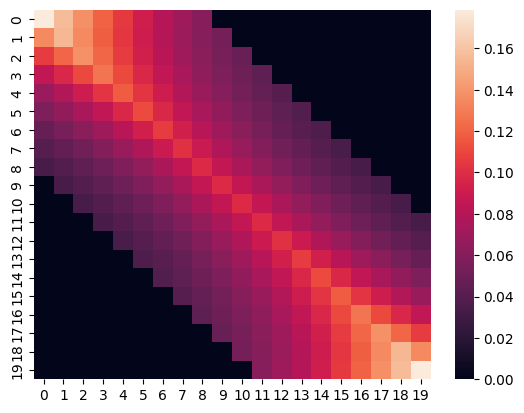

In [13]:
cf = ArtmModel(5, 10, 20, 8).context_coeffs
sns.heatmap(cf)
plt.show()

In [ ]:
class UnitSimplexProjectionOptimizer(torch.optim.Optimizer):
    def __init__(self, params, eps=1e-8):
        super().__init__(params, defaults={'eps': eps})

        self._eps = eps

    def _norm(self, x: torch.Tensor) -> torch.Tensor:
        # take x+ = max(x, 0) element-wise (perform projection on positive simplex)
        x = torch.maximum(x, torch.zeros_like(x))
        # normalize values in non-zero rows to 1 (mapping from the positive simplex to the unit simplex)
        norm = x.sum(dim=0)
        x[norm > self._eps] /= norm[norm > self._eps]
        return x

    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                param.data = self._norm(param.data * param.grad.data)